## Hotel Booking Analysis and Forecasting

### A- Importing libraries & data

In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py

In [3]:
#loading data
pwd = os.getcwd()
dataframe = pd.read_csv(pwd + '//data/hotel_bookings.csv')
pd.set_option("display.max_column", 40)

### B- Data exploring and cleaning

In [4]:
# null values
dataframe.isnull().sum()
#fixing the null values
#if agent value is missing, then customer booked directly (0 is used). Same for company name if it missing it is assumed it is private customer.
Null_values_fix = {"children" : 0.0, "agent": 0.0, "company": 'private', 'country': 'Unspecified'}
dataframe.fillna(Null_values_fix, inplace=True)

#fixing data types
dataframe['children']= dataframe['children'].astype(int)

In [5]:
#interesting values to investigate
dataframe.describe()

# A- rows with 0 adults & 0 childern & 0 babes
dataframe.loc[(dataframe['adults'] + dataframe['children'] + dataframe['babies'] == 0) & (dataframe['adr'] > 0)]
    # rows with zero guests and adr >0 is considered data entry mistake & fixed with adult =1
    # rows with zero guests and adr =0 is left as cancelled booking
zero_guest_fix = list (dataframe.loc[(dataframe['adults'] + dataframe['children'] + dataframe['babies'] == 0) & (dataframe['adr'] > 0)].index)
dataframe['adults'].iloc[zero_guest_fix] = dataframe['adults'].iloc[zero_guest_fix].replace(0, 1)

# B- rows with negative adr (adr is the rate per room per night)
    #one row only, customer was assigned room H instead of room A. replacing the negative adr with 0 
dataframe.loc[dataframe['adr'] < 0]
dataframe['adr'].loc[dataframe['adr'] < 0] = dataframe['adr'].loc[dataframe['adr'] < 0].replace( -6.38, 0)


C:\Users\15146\anaconda3\envs\min_data\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


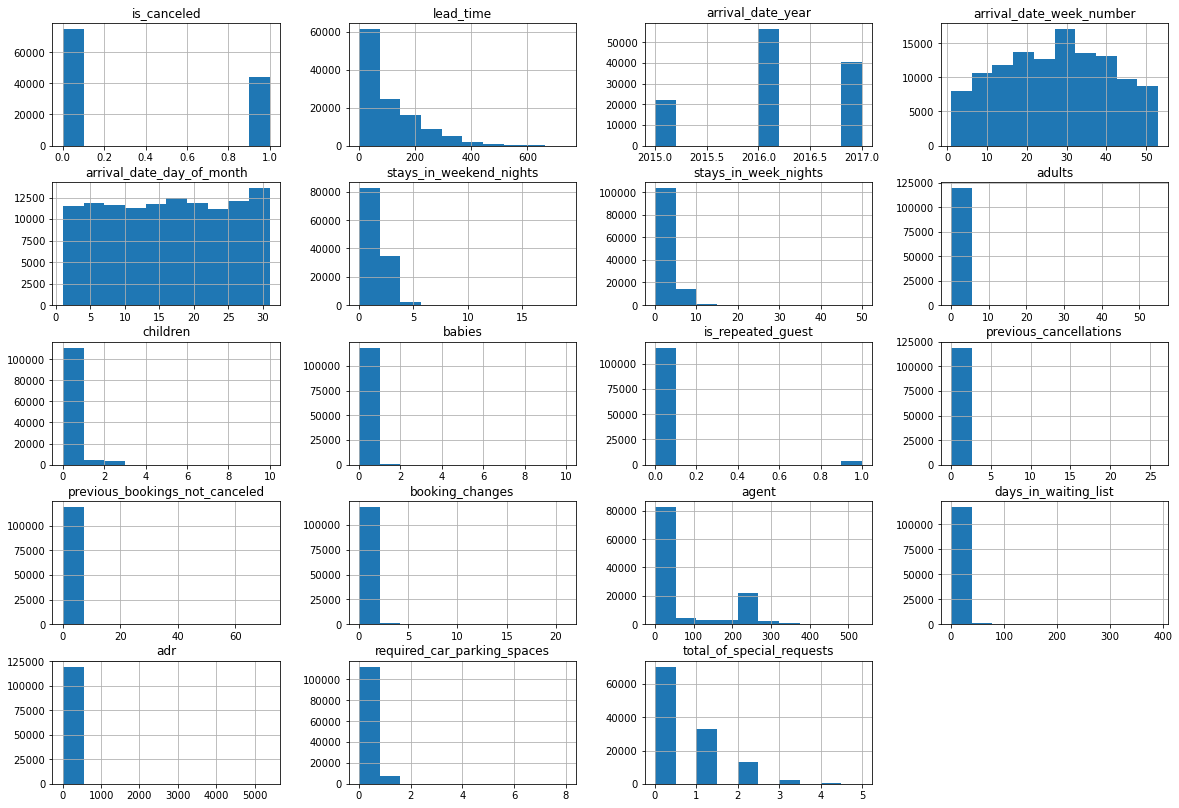

In [6]:
# data exploring
dataframe.hist(figsize= (20, 14))
plt.show()

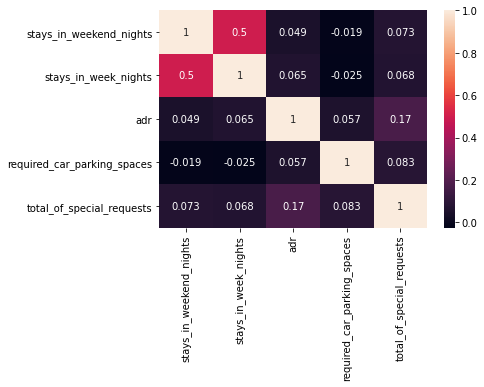

In [7]:
interesting_corr_columns = [ 'stays_in_weekend_nights','stays_in_week_nights',  'adr','required_car_parking_spaces', 'total_of_special_requests']
correlation_matrix = dataframe[interesting_corr_columns].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

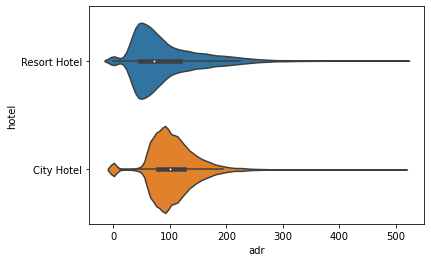

In [8]:
#exploring the daily room rate in different hotel types
sns.violinplot(x='adr', y='hotel', data=dataframe.loc[dataframe['is_canceled'] == 0])
plt.show()

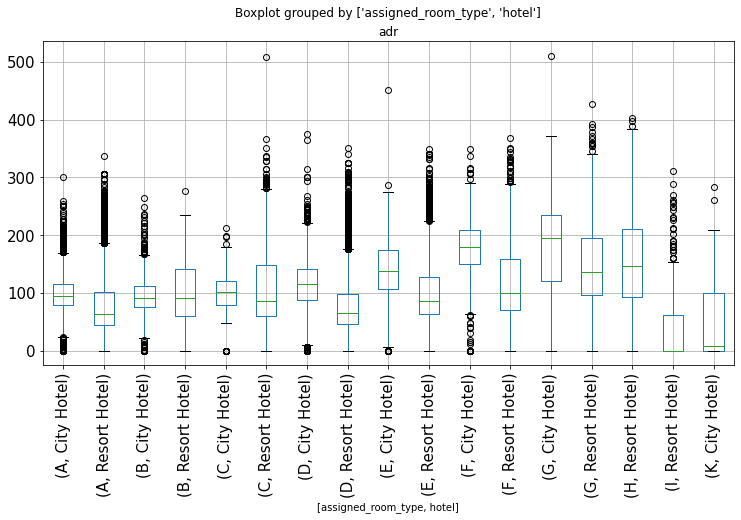

In [9]:
# exploring the diffferent rates (for the uncancelled booking) based on the hotel and room type
dataframe.loc[dataframe['is_canceled'] == 0].boxplot(column= 'adr', by=['assigned_room_type', 'hotel'], figsize = (12,6), fontsize= 15)
plt.xticks(rotation='vertical', size = 15)
plt.show()

In [10]:
#creating contineous arrival date column 
dataframe[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']]
dataframe['arrival_date'] = dataframe['arrival_date_day_of_month'].map(str) + '-' + dataframe['arrival_date_month'] + '-' + dataframe['arrival_date_year'].map(str)
dataframe['arrival_date'] =pd.to_datetime(dataframe['arrival_date'],format="%d-%B-%Y")

#creating the total stay-in column and revenue per booking
dataframe['total_stay_in'] = dataframe['stays_in_weekend_nights'] + dataframe['stays_in_week_nights']
dataframe['revenue'] = dataframe['total_stay_in'] * dataframe['adr']

In [11]:
#based on the adr difference between hotel types, I decided to divid the data into two datsets
df_resort = dataframe.loc[dataframe['hotel'] == 'Resort Hotel']
df_city = dataframe.loc[dataframe['hotel'] != 'Resort Hotel']

### C - Business Data Analysis

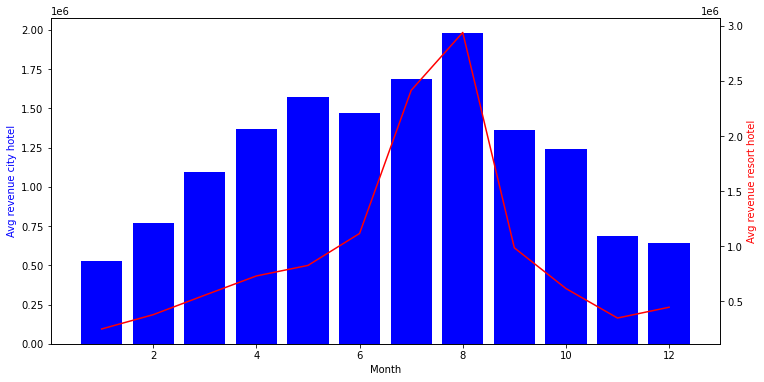

In [17]:
# C-1- Is there any trend in revenue by hotel type? which type of hotel generates more revenue?

#grouping revenue by month
city_revenue = df_city.loc[df_city['is_canceled'] == 0].groupby('arrival_date_month').sum()['revenue'].reset_index()
resort_revenue = df_resort.loc[df_resort['is_canceled'] == 0].groupby('arrival_date_month').sum()['revenue'].reset_index()

#creating a new table for the results
city_revenue.columns = ['month', 'city_hotel_revenue']
resort_revenue.columns = ['month', 'resort_hotel_revenue']
avg_monthly_revenue = pd.merge(left = city_revenue, right= resort_revenue, left_on='month', right_on='month')

#sorting dataframe by month
avg_monthly_revenue['month'] = pd.to_datetime(avg_monthly_revenue['month'],format="%B").dt.month
avg_monthly_revenue = avg_monthly_revenue.sort_values(by='month')

#plotting
fig, ax1 = plt.subplots(figsize = (12,6))
ax2 = ax1.twinx()
ax2.plot(avg_monthly_revenue['month'], avg_monthly_revenue['resort_hotel_revenue'], color = 'r')
ax1.bar(avg_monthly_revenue['month'], avg_monthly_revenue['city_hotel_revenue'], color = 'b')
ax1.set_xlabel('Month')
ax2.set_ylabel('Avg revenue resort hotel', color = 'r')
ax1.set_ylabel('Avg revenue city hotel' , color = 'b')
plt.show()

## CONCLUSION: with the scale of y axis in mind, it it clear the resort hotels generate more revenue escpecially during the peak summer season
## i don't like the scale of y axis

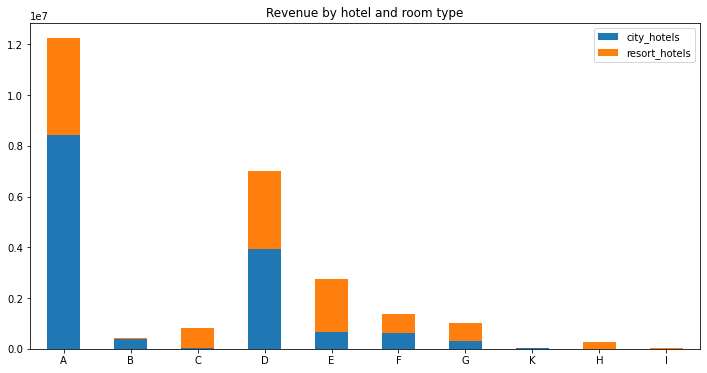

In [13]:
# C-2 What are room type that generated the most revenue?

#grouping revenue by room
city_rooms = df_city.loc[df_city['is_canceled'] == 0].groupby('assigned_room_type').sum()['revenue'].reset_index()
resort_rooms = df_resort.loc[df_resort['is_canceled'] == 0].groupby('assigned_room_type').sum()['revenue'].reset_index()

#creating a new table for the results
city_rooms.columns = ['room', 'city_hotels']
resort_rooms.columns = ['room', 'resort_hotels']

#merging and fixing null
room_revenue = pd.merge(left = city_rooms, right= resort_rooms, left_on='room', right_on='room', how='outer')
room_revenue.fillna(0, inplace=True)

#plotting

room_revenue.plot(kind = 'bar', stacked = True, figsize = (12,6))
plt.title('Revenue by hotel and room type')
plt.xticks(ticks = room_revenue.index, labels= room_revenue['room'], rotation=0, ha='center')
plt.show()

## CONCLUSION: room type A , D are the most revenue generating types of rooms specially in city hotels. Room type E in resort hotels is generating significanlty more revenue than the same type in city hotels

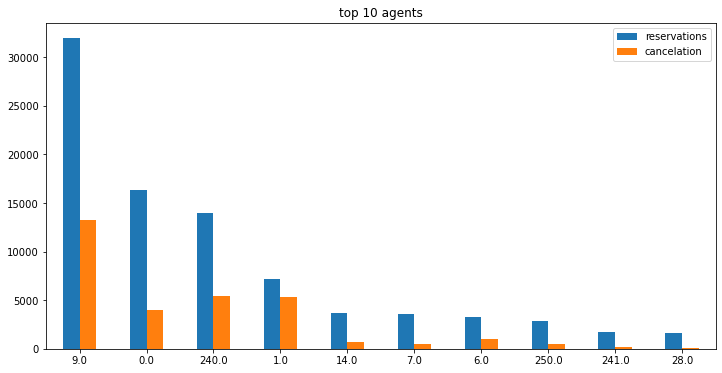

In [14]:
# C-3 who are the most successful agents and what is reservation/concelation ratio for them?
agents_count = dataframe.groupby('agent').count()['hotel'].reset_index()
agents_cancelation = dataframe.groupby('agent').sum()['is_canceled'].reset_index()

## creating new tables for the results
agents_count.columns = ['agent_id', 'reservations']
agents_cancelation.columns = ['agent_id', 'cancelation']
agents = agents_count.merge( right = agents_cancelation, left_on='agent_id', right_on='agent_id')
agents = agents.sort_values(by='reservations', ascending= False).reset_index(drop= True)

#selecting the top 10 agents and plotting
top_agents = agents[:10]
top_agents.plot(kind = 'bar',y= ['reservations', 'cancelation'], stacked = False, figsize = (12,6))
plt.title('top 10 agents')
plt.xticks(ticks = top_agents.index, labels= top_agents['agent_id'], rotation=0, ha='center')
plt.show()


## CONCLUSION: agent with id 9 is the most successful even through the cancelation is somehow high. 2nd position is booking/reservation happen directly (agent 0). There is an interesting case of agent 1 as cancelation ratio is significantlly higher than overage.

In [24]:
# C-4 Market segement pie chart for both hotel types

#group by market segment
city_market = df_city.loc[df_city['is_canceled'] == 0].groupby('market_segment').sum()['revenue'].reset_index()
resort_market = df_resort.loc[df_resort['is_canceled'] == 0].groupby('market_segment').sum()['revenue'].reset_index()

#creating a new table for the results
city_market.columns = ['market_segment', 'city_hotels']
resort_market.columns = ['market_segment', 'resort_hotels']
market_segment = city_market.merge(right=resort_market, on='market_segment', how='outer')
market_segment.fillna(0, inplace=True)
market_segemt = market_segment.sort_values(by='city_hotels', ascending= False).reset_index(drop= True)

#plotting
fig = py.subplots.make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])


fig.add_trace(py.graph_objs.Pie(
     values=market_segment.city_hotels,
     labels=market_segment.market_segment,
     name="City Hotels"), 
     row=1, col=1)

fig.add_trace(py.graph_objs.Pie(
     values=market_segment.resort_hotels,
     labels=market_segment.market_segment,
     name="Resort Hotels"), 
     row=1, col=2)
fig.update_layout(title_text="Market segemts for city hotels 'left' vs resort hotels 'right'")
fig.update_traces(textposition="inside", textinfo="percent+label")
fig.show()


In [25]:
# C-5 Map of the orgin country for the guests
#group by country not cancelled sum total touriests per reservation
guests = dataframe.loc[dataframe['is_canceled'] == 0].groupby('country').sum()['adults'].reset_index()
guests.columns = ['country', 'guest_count']

#plot map

guest_map = py.express.choropleth(guests, locations = 'country', locationmode = 'ISO-3',  hover_name='country', color=guests['guest_count'], 
            color_continuous_scale=py.colors.sequential.Plasma, title="Home country of guests")
guest_map.show()

In [ ]:
# C-2- who are the most frequent customers?
## most important cooperative customer

## most important privte cusotomers/tourists pie chart ( contient)



## most busy weeks of the year

## most desired room type

## which nationality got the most special requests

## most requested meals

## which nationally stayed longesst

## accupancy over time(retructure the dataframe)

## who the customers who bring childrens and babies


##Car parking spaces

## customer type


In [ ]:
# c-3 